### import

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from pyqpanda import *
from sklearn.linear_model import Ridge
from mpl_toolkits.mplot3d import Axes3D
%matplotlib widget

### Lorenz63

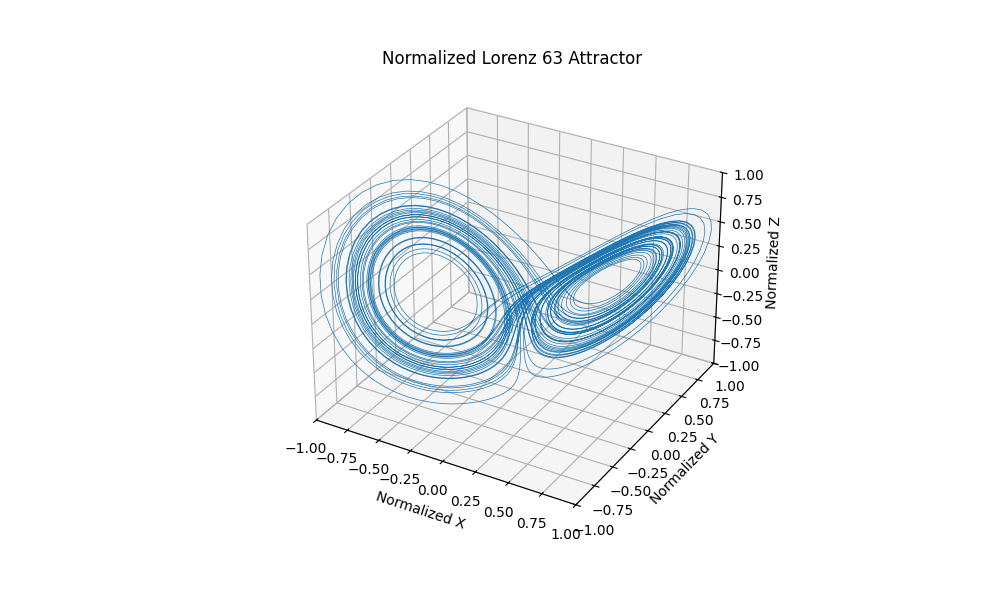

Time Step 0: x=0.096901, y=-0.046119, z=0.016720
Time Step 1: x=0.080919, y=-0.043865, z=-0.017898
Time Step 2: x=0.066744, y=-0.041649, z=-0.051374
Time Step 3: x=0.054193, y=-0.039575, z=-0.083776
Time Step 4: x=0.043087, y=-0.037722, z=-0.115163
Time Step 5: x=0.033257, y=-0.036149, z=-0.145590
Time Step 6: x=0.024543, y=-0.034896, z=-0.175104
Time Step 7: x=0.016795, y=-0.033992, z=-0.203746
Time Step 8: x=0.009876, y=-0.033456, z=-0.231553
Time Step 9: x=0.003660, y=-0.033301, z=-0.258557
Time Step 10: x=-0.001971, y=-0.033534, z=-0.284786
Time Step 11: x=-0.007121, y=-0.034163, z=-0.310264
Time Step 12: x=-0.011887, y=-0.035192, z=-0.335014
Time Step 13: x=-0.016356, y=-0.036626, z=-0.359054
Time Step 14: x=-0.020611, y=-0.038472, z=-0.382401
Time Step 15: x=-0.024723, y=-0.040739, z=-0.405069
Time Step 16: x=-0.028760, y=-0.043437, z=-0.427070
Time Step 17: x=-0.032787, y=-0.046582, z=-0.448413
Time Step 18: x=-0.036861, y=-0.050192, z=-0.469106
Time Step 19: x=-0.041040, y=-0.0

In [5]:
def RK45(x, func, h):
    """四阶龙格-库塔积分器"""
    K1 = func(x)
    K2 = func(x + h/2*K1)
    K3 = func(x + h/2*K2)
    K4 = func(x + h*K3)
    return x + h/6*(K1 + 2*K2 + 2*K3 + K4)

def L63_rhs(x, sigma=10.0, rho=28.0, beta=8/3):
    """定义Lorenz 63微分方程"""
    dx = np.zeros(3)
    dx[0] = sigma * (x[1] - x[0])
    dx[1] = rho*x[0] - x[1] - x[0]*x[2]
    dx[2] = x[0]*x[1] - beta*x[2]
    return dx

def integrate_lorenz63(x0, num_steps=5000, dt=0.01):
    """执行数值积分"""
    trajectory = np.zeros((num_steps, 3))
    trajectory[0] = x0
    for t in range(1, num_steps):
        trajectory[t] = RK45(trajectory[t-1], L63_rhs, dt)
    return trajectory

def normalize_trajectory(trajectory):
    """将轨迹归一化到[-1, 1]范围"""
    # 计算每个坐标轴的极值
    mins = np.min(trajectory, axis=0)
    maxs = np.max(trajectory, axis=0)
    
    # 线性归一化公式：new = 2*(original - min)/(max - min) - 1
    normalized = 2 * (trajectory - mins) / (maxs - mins) - 1
    return normalized

# 参数设置
x0 = np.array([1.508870, -1.531271, 25.46091])  # 混沌初值
traj = integrate_lorenz63(x0)

# 应用归一化
traj_normalized = normalize_trajectory(traj)

# 绘制归一化后的轨迹
fig = plt.figure(figsize=(10,6))
ax = fig.add_subplot(111, projection='3d')
ax.plot(traj_normalized[:,0], traj_normalized[:,1], traj_normalized[:,2], lw=0.5)
ax.set_xlim([-1, 1])
ax.set_ylim([-1, 1])
ax.set_zlim([-1, 1])
ax.set_xlabel("Normalized X")
ax.set_ylabel("Normalized Y")
ax.set_zlabel("Normalized Z")
plt.title("Normalized Lorenz 63 Attractor")
plt.show()

# 输出前1000步归一化后的坐标
for t in range(1000):
    x_norm, y_norm, z_norm = traj_normalized[t]
    print(f"Time Step {t}: x={x_norm:.6f}, y={y_norm:.6f}, z={z_norm:.6f}")


### 8-qubit machine

In [ ]:
# 在循环开始前初始化列表
all_sorted_values = []
# 对于8个量子比特，可能的状态总数是2^8=256
n_states = 256
# 初始化256个参数
params = [0.5*np.pi] * 256 

for i in range(2):
    x_norm, y_norm, z_norm = 4*np.pi*traj_normalized[i]
 
    if i > 0 and len(all_sorted_values) > 0:
       # 使用上一次的sorted_values更新参数
       prev_values = all_sorted_values[-1]
       for j in range(min(len(prev_values), 256)):
           params[j] = prev_values[j] *4*np.pi

    # 初始化量子虚拟机
    qvm = CPUQVM()
    qvm.init_qvm()
    n_qubits = 8
    n_cbits = 8

    # 分配量子比特和经典比特
    qubits = qvm.qAlloc_many(n_qubits)
    cbits = qvm.cAlloc_many(n_cbits)
    shots = 10000000
    # 构建量子程序
    prog = QProg()
    circuit = QCircuit()
    # 使用256个参数构建电路
    param_index = 0
    for layer in range(32):  # 32层，每层使用8个参数
        for qubit in range(8):
            circuit << RY(qubits[qubit], params[param_index])
            param_index += 1
            if qubit < 7:
                circuit << CNOT(qubits[qubit], qubits[qubit+1])
        circuit << CNOT(qubits[7], qubits[0])
    # 添加Lorenz坐标相关的门
    circuit << RY(qubits[0], x_norm) 
    circuit << CNOT(qubits[0], qubits[1]) 
    circuit << RY(qubits[1], y_norm) 
    circuit << CNOT(qubits[1], qubits[2]) 
    circuit << RY(qubits[2], z_norm)
    circuit << CNOT(qubits[2], qubits[3])
    circuit << CNOT(qubits[3], qubits[4])
    circuit << CNOT(qubits[4], qubits[5])
    circuit << CNOT(qubits[5], qubits[6])
    circuit << CNOT(qubits[6], qubits[7])
    circuit << CNOT(qubits[7], qubits[0]) 
    #circuit << 参数\beta
    prog << circuit << measure_all(qubits, cbits)
    # 运行多次量子程序，并返回测量结果
    result = qvm.run_with_configuration(prog, cbits, shots)
    #result2 = qvm.prob_run_dict(prog, qubits, -1)
    # 计算概率分布
    total = shots
    probabilities = {}
    
    # 确保所有可能的状态都有值
    for state_idx in range(n_states):
        # 将索引转换为8位二进制字符串
        state = format(state_idx, '08b')
        # 如果状态在结果中，使用实际概率；否则为0
        probabilities[state] = round(result.get(state, 0) / total, 7)
    
    # 确保按照状态排序，而不是按照概率值排序
    sorted_states = sorted(probabilities.keys())
    sorted_values = [probabilities[state] for state in sorted_states]

            #print(f"时间步 {i}, 数据长度: {len(sorted_values)}")

    # 输出每个时间步的数据，用于测试检查
    print(f"时间步 {i}, 数据长度: {len(sorted_values)}")
    print(sorted_values)      

    # 保存本次的sorted_values，用于下一次循环
    all_sorted_values.append(sorted_values)

    qvm.finalize()

# 将数据转换为numpy数组并保存
all_sorted_values_array = np.array(all_sorted_values)
np.save('/Users/dyy/github/QRC_project1/training_data.npy', all_sorted_values_array)

# 打印完整数据
print("全部数据:")
for i, values in enumerate(all_sorted_values):
    print(f"时间步 {i}:")
    print(values)


# 打印数据形状
print(f"数据形状: {all_sorted_values_array.shape}")
print(f"第一个时间步的数据长度: {len(all_sorted_values[0])}")
print(f"最后一个时间步的数据长度: {len(all_sorted_values[-1])}")

# 检查所有时间步的数据长度是否一致
lengths = [len(values) for values in all_sorted_values]
if len(set(lengths)) == 1:
    print(f"所有时间步的数据长度一致: {lengths[0]}")
else:
    print(f"警告: 数据长度不一致! 长度分布: {set(lengths)}")
